This notebook creates a daily timeseries of precipitation data for each California climate division, based on GHCN daily data.

In [1]:
""" Initialize the notebook """
%matplotlib inline
import pylab as PP
import os
import matplotlib as mpl
import collections
import datetime as dt
import netCDF4 as nc
import fastkde.fastKDE as fastKDE
import scipy.integrate
import pandas as pd

import fiona # for dealing with shapefiles
import shapely.ops # for polygon unions
import shapely.geometry # for doing point-in-polygon
from descartes import PolygonPatch # for converting shapely objects to matplotlib PolygonPatch objects
from matplotlib.collections import PatchCollection # for efficiently drawing many polygons

from numpy import *


#Set the default font for plots
font = { 'family' : 'sans-serif', \
         'size' : '15', \
         'weight' : 'bold'}
mpl.rc('font', **font)

ghcnd_directory = '/projects/data/GHCND/'

print("{}:{}".format('butler',os.getcwd()))

butler:/projects/collaborations/ghcn_daily_climate_div_precip


In [2]:
""" Read in the station list """

with open(ghcnd_directory + 'ghcnd-stations.txt') as fin:
    station_ids, lats, lons = zip(* [line.split()[:3] for line in fin.readlines()])
    
# convert lat and lon to numpy arrays
lats = array([ float(l) for l in lats ])
lons = array([ float(l) for l in lons ])

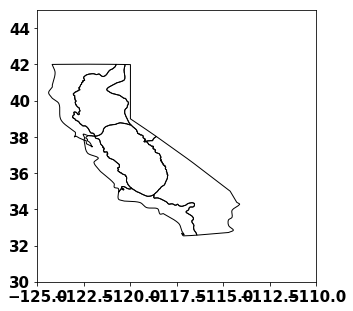

In [3]:
""" Read in the CA climate divison shapefiles """

#initialize dictionaries for storing shapefile information
geometry_by_division = {}
coordinates_by_division = {}

# open the world border shapefile
with fiona.collection('./climate_div.shp') as fin:
    # loop through divisions
    for record in fin:
        
        # get the division name
        division_name = record['properties']['NAME']
        
        # only extract california divisions
        if record['properties']['ST'] == 'CA':
            division_number = record['properties']['DIV_']
            
            # get the coordinates of the division boundaries (a list of list of coordinates)
            coordinates_by_division[division_number] = record['geometry']['coordinates']

            # store the geometries in a nice format for matplotlib visualization
            geometry_by_division[division_number] = shapely.geometry.shape(record['geometry'])
            
            
"""visualize all divisions """
fig,ax = PP.subplots(figsize=(5,5))

# add polygon patches for each division
patches = [ PolygonPatch(geometry_by_division[div],fc='none',ec='k',zorder=2, lw=1) for div in geometry_by_division]

# draw the polygon patches
ax.add_collection(PatchCollection(patches, match_original=True))

# set plot bounds
ax.set_xlim([-125,-110])
ax.set_ylim([30,45])

# turn off axes
#ax.axis('off')

# draw
PP.show()

In [4]:
""" Find the stations within each climate division """
# initialize an empty station dictionary
stations_by_division = { key : [] for key in geometry_by_division }
for i in range(len(lats)):
    # get the current station's lat/lon
    lat = lats[i]
    lon = lons[i]
    # create a shapely point out of it
    point = shapely.geometry.Point(lon,lat)
    # loop over the climate division shapes and check if the point is within
    for division in geometry_by_division:
        if point.within(geometry_by_division[division]):
            # if so, append the station ID to the list
            stations_by_division[division].append(station_ids[i])
            
for key in geometry_by_division:
    print("Climate Division {} has {} stations within".format(key,len(stations_by_division[key])))

Climate Division 1 has 409 stations within
Climate Division 2 has 496 stations within
Climate Division 3 has 94 stations within
Climate Division 5 has 354 stations within
Climate Division 4 has 325 stations within
Climate Division 7 has 250 stations within
Climate Division 6 has 568 stations within


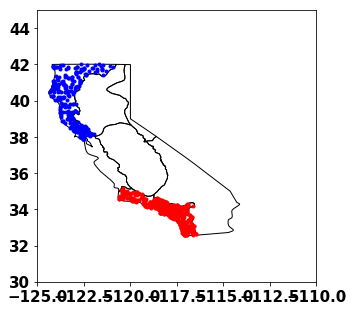

In [5]:
""" plot the points in CD1 and CD6 """
fig,ax = PP.subplots(figsize=(5,5))

# add polygon patches for each division
patches = [ PolygonPatch(geometry_by_division[div],fc='none',ec='k',zorder=2, lw=1) for div in geometry_by_division]

# draw the polygon patches
ax.add_collection(PatchCollection(patches, match_original=True))

# set plot bounds
ax.set_xlim([-125,-110])
ax.set_ylim([30,45])

# turn off axes
#ax.axis('off')

# get the indices for CD1 and CD6
inds_cd1 = nonzero([ station in stations_by_division[1] for station in station_ids])[0]
inds_cd6 = nonzero([ station in stations_by_division[6] for station in station_ids])[0]

# plot CD1 and CD6 stations
ax.plot(lons[inds_cd1],lats[inds_cd1],'b.')
ax.plot(lons[inds_cd6],lats[inds_cd6],'r.')

# draw
PP.show()

In [6]:
""" Write a function to read GHCN data """
"""
Note that I got this information from the `readme.txt` file in the GHCND directory that describes the data format.
The relevant section of the `readme.txt` file is below:

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------

III. FORMAT OF DATA FILES (".dly" FILES)

Each ".dly" file contains data for one station.  The name of the file
corresponds to a station's identification code.  For example, "USC00026481.dly"
contains the data for the station with the identification code USC00026481).

Each record in a file contains one month of daily data.  The variables on each
line include the following:

------------------------------
Variable   Columns   Type
------------------------------
ID            1-11   Character
YEAR         12-15   Integer
MONTH        16-17   Integer
ELEMENT      18-21   Character
VALUE1       22-26   Integer
MFLAG1       27-27   Character
QFLAG1       28-28   Character
SFLAG1       29-29   Character
VALUE2       30-34   Integer
MFLAG2       35-35   Character
QFLAG2       36-36   Character
SFLAG2       37-37   Character
  .           .          .
  .           .          .
  .           .          .
VALUE31    262-266   Integer
MFLAG31    267-267   Character
QFLAG31    268-268   Character
SFLAG31    269-269   Character
------------------------------
"""
# use an ordered dictionary to store the information
# (we can use the dictionary keys later as column headers)
bounds = collections.OrderedDict()

# translate the information from the `readme.txt` table into tuples of column boundaries
# for each column
bounds['ID'] = (0,11)
bounds['YEAR'] = (11,15)
bounds['MONTH'] = (15,17)
bounds['ELEMENT'] = (17,21)
# set the widths of the VALUE*, MFLAG*, QFLAG*, and SFLAG* columns
widths = collections.OrderedDict()
widths['VALUE'] = 5
widths['MFLAG'] = 1
widths['QFLAG'] = 1
widths['SFLAG'] = 1

# set the current column index
current_index = 21
# loop through the VALUE*, MFLAG*, QFLAG*, and SFLAG* values and set the columns for each day
for i in range(31):
    for key in widths:
        bounds['{}{}'.format(key,i+1)] = (current_index,current_index + widths[key])
        current_index += widths[key]
        
# create a list of column indicies, suitable for input into pandas.read_fwf()
column_inds = [bounds[key] for key in bounds]

# create a list of the 'values columns'
value_columns = [ 'VALUE{}'.format(i) for i in range(1,32)]
# create a list of the 'QFLAG columns'
qc_columns = [ 'QFLAG{}'.format(i) for i in range(1,32)]

default_fill_date = dt.date(1750,1,1)
def date_or_fill(y,m,d):
    """ Construct a datetime.date object from a given year month and day.
    
        If these don't constitute a valid date, return a fill_date.
        
        """
    try:
        date = dt.date(y,m,d)
    except:
        date = default_fill_date

    return date


def read_ghcnd_variable(filename, \
                    varname = "PRCP", \
                    omit_qc_values = True, \
                    omit_missing_values = False):
    """
    Reads a GHCND '.dly' file and extracts data for a single variable.
    
    input:
    ------
        
        filename       : the path to a GHCHD '.dly' file (can be any type of path readable by pandas,
                         including a URL)
        
        varname        : the name of the variable ('ELEMENT' in the GHCND `readme.txt`) to extract
        
        omit_qc_values : flags whether to simply omit data values for which there is a quality control flag
        
        omit_missing_values : flags whether to simply omit missing values
        
        
    output:
    -------
    
        returns a tuple of numpy vectors: (data, dates, [qcflags])
        
        data : a vector of data for the given varname in the given GHCND file
        
        dates : the dates for each datum
        
        qcflags : (optional) the quality control flags for each datum; False if there is a QC issue.  
                  (Not returned if omit_qc_values is True.)
    
    """
    

    #1. Load the file with pandas

    # load the file with pandas
    ghcnd_frame = pd.read_fwf(filename,colspecs=column_inds,names=bounds.keys())
    
    #2. Subselect the desired variable and extract the column values
    
    # get the rows that have data for the desired variable
    ivar = ghcnd_frame['ELEMENT'] == varname
    
    # get a table of only the desired data values
    var_dataframe = ghcnd_frame[value_columns][ivar]
    
    #3. Convert the resulting table into a vector using numpy.ravel()
    var_data = array(var_dataframe).ravel()
    
    #4. Attempt to create a matrix of datetime objects (using 'i' as the day in 'VALUEi') for each value
    # * use try/except; it will fail for some days (e.g., April 31 and Feb 29 for non-leap years).  Return
    #   a 'fill date' for any bad dates.  This will tell us which data correspond to non-existing days.
    # * use numpy.ravel() to ravel this into a vector as well; the resulting vector should have the same
    #   length as the variable vector from step 3.
    
    # extract the year/month columns
    years = ghcnd_frame['YEAR'][ivar]
    months = ghcnd_frame['MONTH'][ivar]
    
    # create a vector of dates
    date_vector = array([ date_or_fill(y,m,d) for y,m in zip(years,months) for d in range(1,32) ])
    
    #5. Use numpy indexing to remove any bad dates from the vectors.  Either remove or set a fill value for any
    #data that have a QC flag (maybe this is a user-controlled behavior?)
    
    # get the indices of valid dates
    good_date_inds = [ i for i in range(len(date_vector)) if date_vector[i] != default_fill_date]
    # set the variable and date vectors to the subset of valid dates
    var_data = var_data[good_date_inds]
    date_vector = date_vector[good_date_inds]
    
    #5. Also extract a table of the quality-control flags.  If a QC item is present, then set the matrix to 1;
    #otherwise set it to 0.  Use numpy.ravel() to also convect this to a vector.
    qc_dataframe = ghcnd_frame[qc_columns][ivar]
    qc_vector = array(qc_dataframe).ravel()
    qc_vector = qc_vector[good_date_inds]
    # if there are missing values, then pandas sets the qc_vector type to object; so we need to
    # deal with storage of mixed data types.  I do this by treating the objects as string.
    #
    # Note also that the presence of NaN in the qc_vector indicates no value stored for the QC flag; meaning
    # that the datum at that point/time is good.
    if qc_vector.dtype == 'object':
        good_qc_inds = nonzero([ True if str(item) == 'nan' else False for item in qc_vector ])[0]
    else:
        good_qc_inds = isnan(qc_vector)
    
    if omit_qc_values:
        # omit quality control variables if flagged
        var_data = var_data[good_qc_inds]
        date_vector = date_vector[good_qc_inds]
    
    #7. Deal with missing data
    var_data = ma.masked_equal(var_data,-9999.)
    date_vector = ma.masked_where(var_data.mask,date_vector)
    if omit_qc_values:
        good_qc_inds = ma.masked_where(var_data.mask,good_qc_inds)
        
    # remove missing values if requested
    if omit_missing_values:
        var_data = var_data.compressed()
        date_vector = date_vector.compressed()
        good_qc_inds = good_qc_inds.compressed()

    #8. Return the resulting vector and the comparable subset of date values
    if omit_qc_values:
        return var_data, date_vector
    else:
        return var_data, date_vector, good_qc_inds

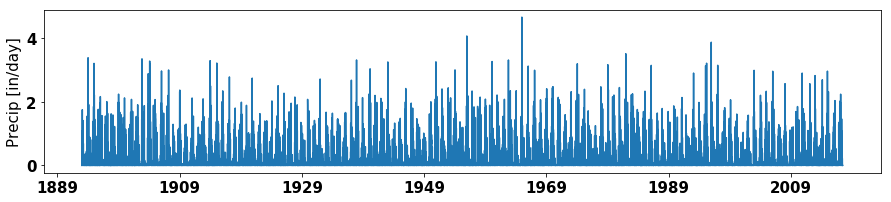

In [7]:
""" Write a function that creates an average timeseries from a collection of GHCN files """

def averageGHCNDStations( station_list, \
                          variable = 'PRCP', \
                          timeseries_start = dt.date(1850,1,1), \
                          timeseries_end = dt.date.today(), \
                          ghcn_base = 'ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/daily/all/'):
    """ Given a list of GHCN Daily stations, produce an average timeseries of those stations.
    
        input:
        ------
            station_list     : a list of GHCND station IDs (from the first column of the `ghcnd-stations.txt` file)
            
            variable         : the GHCND variable for which to calculate the timeseries
            
            timeseries_start : a datetime.date object indicating the first date in the desired timeseries
            
            timeseries_end   : a datetime.date object indicating the last date in the desired timeseries
            
            ghcn_base        : the base path in which the GHCND files reside (can be a URL or path)
            
        output:
        -------
        
            dates, timeseries_avg, timeseries_std, count
            
            
            dates          : a list of datetime objects for the timeseries
            
            timeseries_avg : a numpy masked array of the average of the station data at each time (masked where data
                             are completely missing)
                             
            timeseries_avg : a numpy masked array of the standard deviation of the station data at each time (masked where data
                             are completely missing or where there are less than 2 stations available)
                             
            count          : the number of stations contributing to the average
                             
    """
    #********************************
    # create the master set of dates
    #********************************
    # set the time units
    time_units = 'days since {:04}-{:02}-{:02} 00:00:00'.format(timeseries_start.year,timeseries_start.month,timeseries_start.day)
    # get the number of days
    num_days = (timeseries_end - timeseries_start).days
    # create the time vector
    times = arange(num_days)
    # create the dates
    dates = nc.num2date(times,time_units)
    
    
    # create a master station data array
    num_stations = len(station_list) # number of stations
    data_array = ma.masked_equal(ma.zeros([num_stations,num_days]),0)
    
    # Loop over all stations and read data
    for i in range(num_stations):
        # get the station ID
        station_id = station_list[i]
        
        # set the station path
        station_path = ghcn_base + 'all/{}.dly'.format(station_id)

        # read the station's data
        try:
            data, datetmp = read_ghcnd_variable(station_path,variable,omit_missing_values=True)
        except:
            raise RuntimeError(print(station_path))
        
        if len(data) != 0:
            # convert date objects to dates
            datetmp = [dt.datetime(d.year,d.month,d.day) for d in datetmp]

            # get the indices for the dates in the master array
            inds = array(nc.date2num(datetmp,time_units)).astype(int)

            # deal with out-of-bounds indices
            masked_inds = ma.masked_outside(inds, times[0], times[-1])

            # remove data outside the requested time
            data = ma.masked_where(masked_inds.mask,data).compressed()
            inds = masked_inds.compressed()

            # insert the data into the array
            data_array[i,inds] = data
        
    # calculate the average and standard deviation
    data_average = ma.average(data_array,axis=0)
    data_std = ma.std(data_array,axis=0)
    
    # calculate the number of stations at each time
    data_count = ma.masked_equal(sum(logical_not(data_array.mask),axis=0),0)
    
    data_average = ma.masked_where(data_count.mask,data_average)
    data_std = ma.masked_where(logical_or(data_count.mask, data_count < 2),data_std)
    
    return dates, data_average, data_std, data_count
    
dates, data_average, data_std, data_count = averageGHCNDStations(stations_by_division[1],ghcn_base=ghcnd_directory)

fig, ax = PP.subplots(figsize=(15,3))
ax.plot(dates,data_average/254)
ax.set_ylabel('Precip [in/day]')
PP.show()

In [8]:
""" Create precip timeseries for each climate division """

# initialize dictionaries of arrays
precip_avg_by_division = {}
precip_std_by_division = {}
precip_count_by_division = {}

# loop over all divisions
for key in stations_by_division:
    
    # calculate the average/std/count within each division
    dates, data_average, data_std, data_count = averageGHCNDStations(stations_by_division[key],ghcn_base=ghcnd_directory)

    # store the data in the dictionaries
    precip_avg_by_division[key] = ma.array(data_average)
    precip_std_by_division[key] = ma.array(data_std)
    precip_count_by_division[key] = ma.array(data_count)
    
    # note: not storing date in a dictionary, since it is identical for each

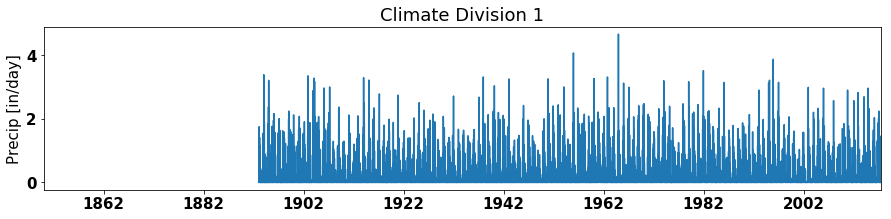

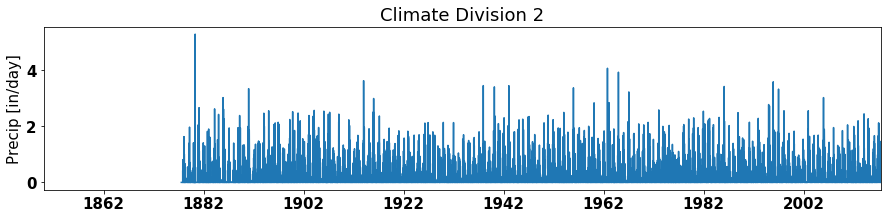

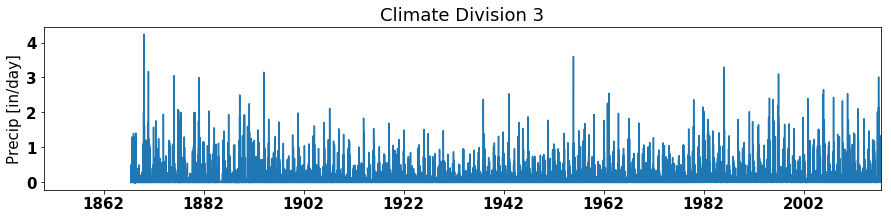

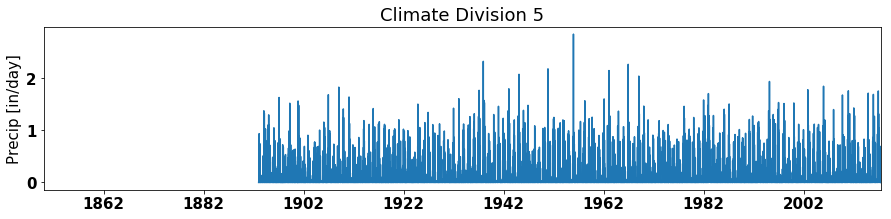

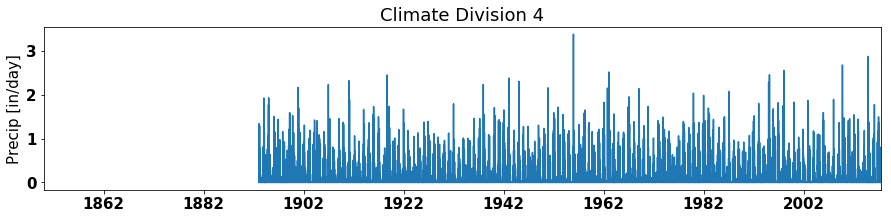

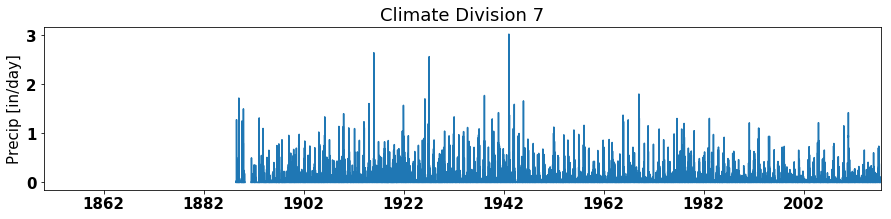

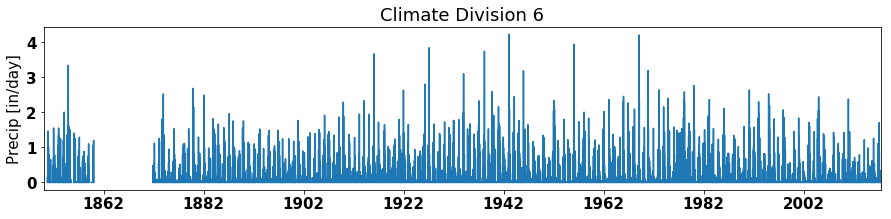

In [9]:
""" Plot the timeseries """
for key in precip_avg_by_division:
    fig, ax = PP.subplots(figsize=(15,3))
    ax.plot(dates,precip_avg_by_division[key]/254)
    ax.set_title('Climate Division {}'.format(key))
    ax.set_ylabel('Precip [in/day]')
    ax.set_xlim([dates[0],dt.datetime.today()])
    PP.show()

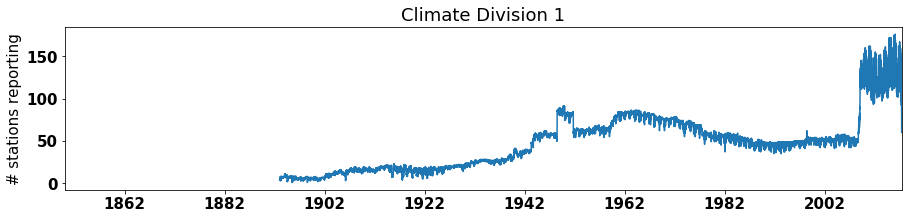

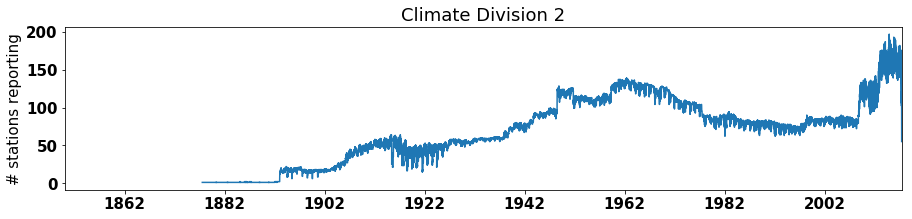

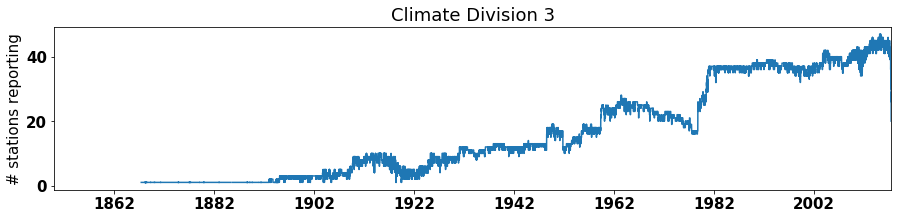

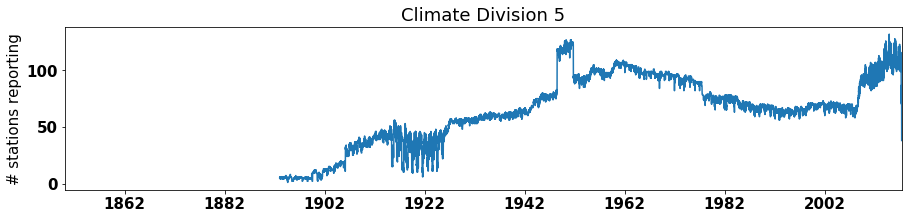

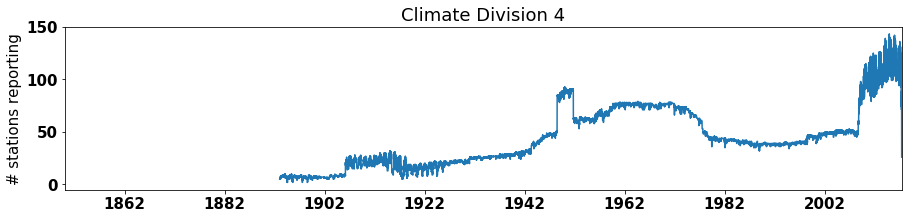

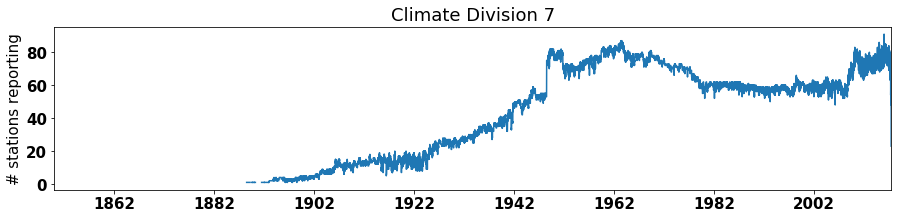

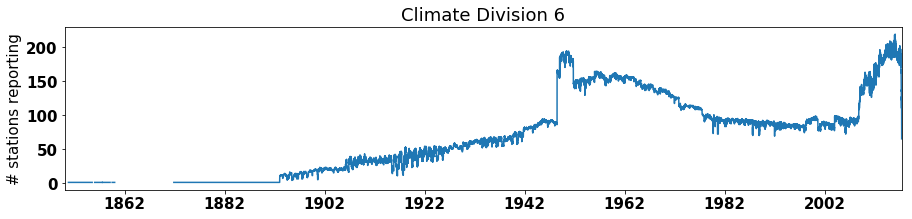

In [10]:
""" Plot the count timeseries """
for key in precip_avg_by_division:
    fig, ax = PP.subplots(figsize=(15,3))
    ax.plot(dates,precip_count_by_division[key])
    ax.set_title('Climate Division {}'.format(key))
    ax.set_ylabel('# stations reporting')
    ax.set_xlim([dates[0],dt.datetime.today()])
    PP.show()

In [11]:
""" Write the timeseries to disk """
out_filename = "ca_climate_division_ghcn_daily.nc"

with nc.Dataset(out_filename,'w') as fout:
    # create dimensions
    fout.createDimension('division',len(precip_avg_by_division))
    fout.createDimension('time',len(dates))
    
    # create dimension variables
    vdiv = fout.createVariable('division','i',('division',))
    vtime = fout.createVariable('time','f8',('time',))
    
    # set dimension metadata
    vdiv.long_name = "Climate division"
    vtime.long_name = 'time'
    vtime.units = 'days since {:04}-{:02}-{:02} 00:00:00'.format(dates[0].year,dates[0].month,dates[0].day)
    
    # create precip variables
    fill_value = precip_avg_by_division[1].fill_value
    vprecip_avg = fout.createVariable('average','f4',('division','time'),fill_value = fill_value)
    vprecip_std = fout.createVariable('std_dev','f4',('division','time'),fill_value = fill_value)
    vprecip_count = fout.createVariable('count','i',('division','time'),fill_value = fill_value)

    # set variable metadata
    vprecip_avg.long_name = "Precipitation average"
    vprecip_avg.units = "mm d-1"
    vprecip_std.long_name = "Precipitation standard deviation"
    vprecip_std.units = "mm d-1"
    vprecip_count.long_name = "Precipitation station count"
    vprecip_count.units = "number"
    
    # write data
    vtime[:] = nc.date2num(dates,vtime.units)
    vdiv[:] = arange(1,8,dtype=int)
    
    for key in precip_avg_by_division:
        vprecip_avg[key-1,:] = precip_avg_by_division[key]/10 # convert to mm
        vprecip_std[key-1,:] = precip_std_by_division[key]/10 # convert to mm
        vprecip_count[key-1,:] = precip_count_by_division[key]